# RNN을 이용한 텍스트 생성기(Text Generator using RNN)
## 샘플 코드를 기반으로 한 텍스트 생성 프로그램입니다.(Text Generator based on sample code)
### 한국어 설명
그럴듯한 텍스트 생성을 위해서는 최소 5000 Epoch의 학습이 필요합니다.
<br> 이 코드는 Keras 예제, Tensorflow 예제와 같은 코드를 참고하여 제작되었습니다.
<br>
<br> 몇가지 유의사항:
<br>- 이 프로그램은 대용량 텍스트 처리에 적합하지 <b>않습니다</b>.
<br>- 이 프로그램은 모든 언어에 대응합니다. (일단, 한국어 구동은 확인했습니다.)
<br>- RNN의 계산량이 매우 많음에 따라 GPU환경에서 구동하는 것을 추천드립니다.
<br>
### EN Version.
At least 5000 epochs are required before the generated text starts sounding coherent.
<br> *(This model is inspired by many examples, such as Keras samples, or tensorflow tutorials.)*
<br>
<br> Few notices:
<br>- This script is <b>NOT</b> designed for large text.
<br>- This script is designed for ANY language. (It works for my language, at least.)
<br>- It is recommended to run this script on GPU, as recurrent networks are quite computationally intensive.

In [1]:
import time
import chardet
import numpy as np
import tensorflow as tf
from tensorflow.contrib import rnn
from tensorflow.contrib.layers import fully_connected
from tensorflow.contrib.seq2seq import sequence_loss
import matplotlib.pyplot as plt

# 그래프 기본값 설정
plt.rcParams["figure.figsize"] = (14, 12)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'r'
plt.rcParams['axes.grid'] = True 

%matplotlib inline

C:\Users\jungw\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Class 상세
- \_\_init\_\_: 인코딩(Encoding) 옵션과 함께 파일을 로드합니다.
    - 기본 인코딩: None
- Slice_Data: 텍스트를 글자 단위로 분할합니다. (올바른 방법으로 수정할 경우, 단어 단위로도 가능)
- Data2idx: 텍스트 데이터를 인덱스(Index)로 변환합니다.
- Build_Data: 변환된 텍스트 데이터를 기반으로 시퀀스를 생성합니다.
    - 기본 Stride: 1
- LSTM_Cell: rnn.MultiRNNCell에서 쓰이는 LSTM 셀 구조
- Make_Text: 텍스트 데이터를 기반으로 텍스트를 생성합니다.
- Elapsed: 작업 경과시간 측정 용도
- Save_Model: 현재 모델을 저장합니다.
    - Default Global_step: 1000
- Load_Model: 특정 모델 파일을 불러옵니다.
- Plot_Iter_Loss: Matplotlib을 사용하여 Iteration대비 Loss를 그래프로 그려줍니다.
- Plot_Time_Loss: 시간대비 Loss를 그래프로 그려줍니다.
- Plot_Time_Iter: Iteration대비 시간 경과를 그래프로 그려줍니다.
- Prepare_Model: 학습을 위한 모델 구조를 생성합니다. (X, Y, weight 등)
- Train: 지정된 Epoch숫자만큼 학습을 진행합니다.

### Class Details
- \_\_init\_\_: Load file with encoding option.
    - Default Encoding: None
- Slice_Data: Split text data into characters (This can be words if modified correctly)
- Data2idx: Transform text data into index
- Build_Data: Generate sequences of transformed text data
    - Default Stride: 1
- LSTM_Cell: A LSTM cell, only to use at rnn.MultiRNNCell
- Make_Text: A random text generator, based on text data
- Elapsed: To calculate time elapsed
- Save_Model: Save current Neural Network model
    - Default Global_step: 1000
- Load_Model: Load specified model file
- Plot_Iter_Loss: Plot loss compared to total iteration, using matplotlib.
- Plot_Time_Loss: Plot loss compared to time.
- Plot_Time_Iter: Plot Time compared to total iteration.
- Prepare_Model: Generate model structure for training (X, Y, weight, etc.)
- Train: Start training model with epoch number followed

In [2]:
class TextGen:
    def __init__(self, full_filename, encode=False):
        try:
            read_file = open(full_filename, 'rb').read()
            if encode is True:
                encode_type = chardet.detect(read_file)['encoding']
                print(encode_type)
            else:
                encode_type = None
            # text = open(full_filename, encoding=None).read().lower()
            text = open(full_filename, encoding=encode_type).read()
            self.text = text
        except:
            self.text = False

    def Slice_Data(self):
        print("Word Slicing...")
        self.char_set = sorted(list(set(self.text)))    # character split
        self.char_indices = dict((c, i) for i, c in enumerate(self.char_set))
        self.indices_char = dict((i, c) for i, c in enumerate(self.char_set))

    def Data2idx(self):
        idx_text = []
        for char in self.text:
            idx_text.append(self.char_indices[char])
        self.text = idx_text

    def Build_Data(self, seq_len, stride = 1):
        print("Generating Number Index...")
        x_data = []
        y_data = []
        for i in range(0, len(self.text) - self.seq_len, stride):
            fill_x = seq_len - len(self.text[i : i+seq_len])
            fill_y = seq_len - len(self.text[i+1 : i+seq_len - 1])
            
            x_text = self.text[i : i+seq_len]
            y_text = self.text[i+1 : i+seq_len - 1]
            
            if fill_x is not 0:
                x_text.extend([0 for i in range(fill_x)])
            elif fill_y is not 0:
                y_text.extend([0 for i in range(fill_y)])

            x_data.append(x_text)
            y_data.append(y_text)
        self.x_data = x_data
        self.y_data = y_data

    def LSTM_Cell(hidden_size):
        # Make a lstm cell with hidden_size (each unit output vector size)
        cell = rnn.BasicLSTMCell(hidden_size, state_is_tuple=True)
        return cell

    def Make_Text(self, sess):
        self.results = sess.run(self.outputs, feed_dict={self.X: self.x_data})
        for j, result in enumerate(self.results):
            index = np.argmax(result, axis=1)
            if j is 0:  # print all for the first result to make a sentence
                print(''.join([self.indices_char[t] for t in index]), end='')
            else:
                print(self.indices_char[index[-1]], end='')

    def Elapsed(start, end):
        total = end - start
        m, s = divmod(total, 60)
        h, m = divmod(m, 60)
        
        if m == 0 and h == 0:
            print("Time Elapsed: {:>3d} sec".format(int(s)))
        elif m != 0 and h == 0:
            print("Time Elapsed: {:>3d} min {:>3d} sec".format(int(m), int(s)))
        else:
            print("Time Elapsed: {:>3d} hour {:>3d} min {:>3d} sec".format(int(h), int(m), int(s)))
            
    def Save_Model(saver, sess, filepath, step=1000):
        save_model = saver.save(sess, filepath, global_step=step)
        print("Model saved in path: %s" % save_model)
        
    def Load_Model(saver, sess, filepath):
        saver.restore(sess, filepath)
        print("Model restored.")
        
    def Plot_Iter_Loss(self):
        plt.figure()
        plt.plot(self.iter_loss)
        plt.xlabel('Iter')
        plt.ylabel('Loss')
        plt.title('Loss vs Epoch')
        plt.show()
        
    def Plot_Time_Loss(self):
        plt.figure()
        plt.plot(self.elapsed, self.iter_loss)
        plt.xlabel('Time(sec)')
        plt.ylabel('Loss')
        plt.title('Loss vs Time')
        plt.show()
        
    def Plot_Time_Iter(self):
        plt.figure()
        plt.plot(self.elapsed)
        plt.xlabel('Iter')
        plt.ylabel('Time')
        plt.title('Iter vs Time')
        plt.show()

    def Prepare_Model(self, seq_len, learning_rate=0.1):
        self.seq_len = seq_len

        # load data
        TextGen.Slice_Data(self)
        TextGen.Data2idx(self)
        TextGen.Build_Data(self, seq_len)

        self.data_dim = len(self.char_set)
        self.hidden_size = len(self.char_set)
        self.num_classes = len(self.char_set)
        self.learning_rate = learning_rate

        print("Text length: %s" % len(self.text))
        print("Character set length: %s" % self.data_dim)    # length check
        print("Dataset X length: %s" % len(self.x_data))    # dataset shape check
        print("Dataset Y length: %s" % len(self.y_data))

        self.batch_size = len(self.x_data)

        self.X = tf.placeholder(tf.int32, [None, self.seq_len])
        self.Y = tf.placeholder(tf.int32, [None, self.seq_len])

        # One-hot encoding
        X_one_hot = tf.one_hot(self.X, self.num_classes)

        # Make a lstm cell with hidden_size (each unit output vector size)
        lstm = TextGen.LSTM_Cell(self.hidden_size)
        multi_cells = rnn.MultiRNNCell([lstm for _ in range(2)], state_is_tuple=True)

        # outputs: unfolding size x hidden size, state = hidden size
        outputs, _states = tf.nn.dynamic_rnn(multi_cells, X_one_hot, dtype=tf.float32)

        # FC layer
        X_for_fc = tf.reshape(outputs, [-1, self.hidden_size])
        outputs = fully_connected(X_for_fc, self.num_classes, activation_fn=None)

        # reshape out for sequence_loss
        self.outputs = tf.reshape(outputs, [self.batch_size, self.seq_len, self.num_classes])

        # All weights are 1 (equal weights)
        weights = tf.ones([self.batch_size, self.seq_len])

        loss = sequence_loss(logits=self.outputs, targets=self.Y, weights=weights)
        self.mean_loss = tf.reduce_mean(loss)
        self.train_op = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.mean_loss)

    def Train(self, sess, epoch, save_at):
        saver = tf.train.Saver()
        
        sess.run(tf.global_variables_initializer())
        print('=' * 20, "{:^20}".format("Training Start"), '=' * 20)

        self.iter_loss = []
        self.elapsed = []
        self.savepath = save_at
        
        start = time.time()
        for i in range(epoch):
            _, l, results = sess.run(
                [self.train_op, self.mean_loss, self.outputs],
                feed_dict={self.X: self.x_data, self.Y: self.y_data})
            for j, result in enumerate(results):
                index = np.argmax(result, axis=1)
                
                if i % 100 == 0 and j == 0:
                    print("\n At step", i, ':',
                        ''.join([self.indices_char[t] for t in index]))
                    print('Loss:', l)
                    end = time.time()
                    TextGen.Elapsed(start, end)
            if i % 1000 == 0:
                TextGen.Save_Model(saver, sess, self.savepath)            
            self.iter_loss.append(l)    # Iteration & Loss
            self.elapsed.append(end-start)    # Elapsed Time & Loss


        print('=' * 20, "{:^20}".format("Training Complete"), '=' * 20)

## 현재 과정 설명
1. 데이터를 로드합니다.
    - 이 경우, 텍스트 데이터의 형태를 띄고 있으면 어떤 데이터든 상관없습니다.
2. Learning Rate를 설정합니다. (여기서는 0.1로 설정했습니다.)
3. 학습을 위한 모델 구조를 설정합니다. 해당 과정은 다음과 같은 과정을 거칩니다.
    - 데이터 분할: 텍스트를 글자 단위로 분할합니다.
    - 데이터 변환: 텍스트 데이터를 인덱스(Index)로 변환합니다.
    - 시퀀스 생성: 변환된 텍스트 데이터를 기반으로 시퀀스를 생성합니다.
    - 기본값 셋팅: data_dim(입력 글자 가지수), hidden_size, num_classes(출력 글자 가지수),
    <br>learning_rate, batch_size(여기서는 시퀀스의 총 길이로 설정)
    - Input 형태 설정: [None, 시퀀스 길이]
    - Truth 형태 설정: [None, 시퀀스 길이]
    - One-hot Encoding 진행
    - LSTM을 2중으로 중첩(2-Layer RNN)
    - dynamic_rnn을 거쳐 output을 생성
    - 마지막으로 FC(Fully Connected, DenseNet)를 거쳐 Output(예측값) 생성
    - 형태 재조정을 위해 reshape
    - Weight값의 초기화(1로 모두)
    - Loss: Tensorflow에서 제공하는 sequence_loss를 통해 진행
    - outputs와 실제 Y값을 비교하여 Loss값 산출
    - Loss 평균으로 계산
    - Optimizer 설정
4. Session을 생성합니다.
5. Model의 저장 경로를 지정
6. 학습을 시작합니다.

## Current process explanation
1. Load Data
    - In this case, it doesn't matter which data you choose as long as it's a text form.
2. Set learning rate. (I set 0.1 in this case.)
3. Build model structure. This process goes with following steps:
    - Data split: Split text into characters
    - Data transformation: Transform text data into indexes
    - Generate sequences: Generate sequences, based on transformed text data
    - Default setting: data_dim(input character classes), hidden_size, num_classes(output character classes),
    <br>learning_rate, batch_size(total sequence length, in this case)
    - Input shape setting: [None, Sequence Length]
    - Truth shape setting: [None, Sequence Length]
    - One-hot Encoding process
    - Stack LSTM twice(2-Layer RNN)
    - Generate output through dynamic_rnn
    - Finally, Generate output through FC(Fully Connected, DenseNet)
    - Use reshape to fix shape for output
    - Initialize Weight value into 1s
    - Loss: Process through 'sequence_loss', from Tensorflow module
    - Calculate Loss by comparing outputs and actual Y(Truth)
    - Calculate average loss
    - Set up optimizer
4. Create Session for training.
5. Set path to save Model
6. Begin training

In [3]:
code_gen = TextGen("SAMPLE.py")
learning_rate = 0.1
code_gen.Prepare_Model(40, learning_rate)

Word Slicing...
Generating Number Index...
Text length: 12033
Character set length: 75
Dataset X length: 11993
Dataset Y length: 11993


In [4]:
sess = tf.Session()
save_at = "C:/Users/jungw/OneDrive/문서/GitHub/Text_Generation/rnn_text.ckpt"
epoch = 3001

code_gen.Train(sess, epoch, save_at)

====================    Training Start    ====================

 At step 0 : 2EEsssssssssssbLqq]]]]]]S33








}}}}
Loss: 4.3187985
Time Elapsed:   1 sec
Model saved in path: C:/Users/jungw/OneDrive/문서/GitHub/Text_Generation/rnn_text.ckpt-1000

 At step 100 : nsent_=s  f,tl(antl(=,a_saa
si

sis_si


Loss: 1.8086567
Time Elapsed:   1 min  12 sec

 At step 200 : neert sd  p,am(ob r(i)s_see0sii
bi
_s:si
Loss: 1.0666565
Time Elapsed:   2 min  26 sec

 At step 300 : neurt t_
 p,anrop
n
')
_oe)0s

_L

_sEVE
Loss: 0.731712
Time Elapsed:   3 min  40 sec

 At step 400 : neurt tm( p.anvoron[']F_CPP_M
N_LO
_LEV

Loss: 0.58638895
Time Elapsed:   4 min  56 sec

 At step 500 : neort tb
 _.anvo
on[')F_CPP_M
N_LOG_LEVE
Loss: 0.49462238
Time Elapsed:   6 min  14 sec

 At step 600 : neort t

 s.anvo
on['TF_CPP_MIN_LOG_LEVE
Loss: 0.48537838
Time Elapsed:   7 min  29 sec

 At step 700 : neort t_
 _,anvi
on['TF_CPP_MIN_LOG_LEVE
Loss: 0.5577709
Time Elapsed:   8 min  45 sec

 At step 800 : nsort t_
 s.env

## 예측 코드 생성
* 학습된 데이터를 기반으로 코드를 생성해 봅시다!

In [5]:
code_gen.Make_Text(sess)

n
ort ns
os.emviron['TF_CPP_MIN_LOG_LEVEL']='2'
import logging
import time
import numpy as np
import tensorflow as tf


ogging.getLogger('tensorflow ).setLeve
(lo
ging.WARNING)

class CharRNN(object):
  def __init__(self, ts_training,
batch_gize, num_unrollings, vocab_size,

              hhidden_size, nax_grad_norm
 embedding_size] num_uayers,
                oarning_rate, model, dropout=0.0, unput_dropout
0.0, use_batch:True):
    self.batch_size = 1atch_size      elf.mum_unrollings)= num_unrollings)     f not use_batch:
      self.batch_size = 1
      self.hum_unrollings)= n
    self.hidden_size,= vidden_size     self.mocab_size = vocab_size
     elf.mex_grad_norm = max_grad_norm
    self.num_uayers-= npm_layers
    self.embedding_size < v
bedding_size]    self.model ==model
    self.eropout = dropout
    self.input_dropout = input_dropout
    if embedding_size <= 0:
      self.input_dize = vocab_size
      self.bnput_dropout)= i.0
    else:
      relf.input_dize = vmbedding_size]  

## 과정 시각화(Process Visualization)
### Iter vs Loss
- Iteration별 Loss 변화 추이를 알아봅니다.

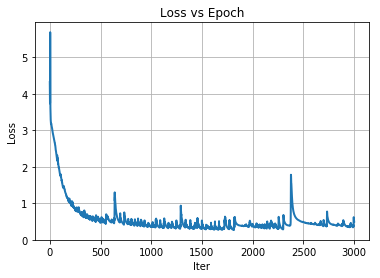

In [6]:
code_gen.Plot_Iter_Loss()

### Time vs Loss
- 시간 경과별 Loss 변화 추이를 알아봅니다.

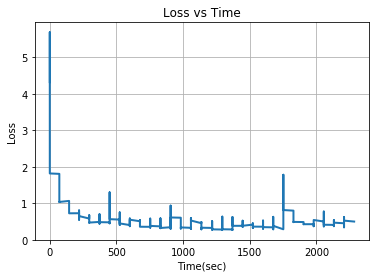

In [7]:
code_gen.Plot_Time_Loss()

### Time vs Iter
- Iteration별 시간 경과 추이를 알아봅니다.

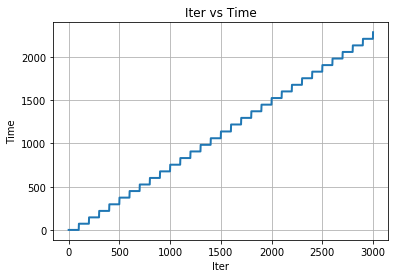

In [8]:
code_gen.Plot_Time_Iter()